## 0.0 Intoduction
Research Qs & hypos

RQ1:What are the peak posting times on Mastodon?

RQ2:How does post length (number of characters) affect engagement (likes, boosts, replies)?

hypos:

Most posts are published during mid-day (12 PM–4 PM).

Longer posts get more replies and favorites.

## 1.0 Import libraries & prerequsites

In [116]:
from datetime import datetime, timedelta, timezone
from mastodon import Mastodon
from bs4 import BeautifulSoup
import pandas as pd
import re
import matplotlib.pyplot as plt
from collections import Counter
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")


In [102]:
pip install --upgrade Mastodon.py

Note: you may need to restart the kernel to use updated packages.


In [107]:
with open('token.txt', 'r') as file:
    ACCESS_TOKEN = file.read().strip()

In [108]:

mastodon = Mastodon(
    access_token=ACCESS_TOKEN,
    api_base_url='https://mastodon.social'
)

print("Connected to Mastodon API")

Connected to Mastodon API


### 1.1 Testing connection 

In [109]:
me = mastodon.account_verify_credentials()
print(me['username'], "is authenticated")


deenakhlewi is authenticated


## 2.0 Collect data

### 2.1 define time window

In [ ]:
end_date = datetime.now(timezone.utc)
start_date = end_date - timedelta(days=30)
print("Collecting posts from", start_date, "to", end_date)

all_posts = []


### 2.2 Fetching posts

In [111]:
#Fetch Many Public Posts (with pagination)
print("Collecting posts...")

all_posts = []
max_id = None  # used to paginate through older posts

while len(all_posts) < 2000: 
    posts_batch = mastodon.timeline_public(limit=40, max_id=max_id)

    if not posts_batch:
        break  # stop when there are no more posts available

    for post in posts_batch:
        content_html = post.get('content', '')
        content_text = BeautifulSoup(content_html, 'html.parser').get_text()

        all_posts.append({
            'username': post['account']['username'],
            'created_at': post['created_at'],
            'content_length': len(content_text),
            'reblogs': post['reblogs_count'],
            'favorites': post['favourites_count']
        })

    # move to the next "page" of older posts
    max_id = posts_batch[-1]['id']

    print(f"Collected so far: {len(all_posts)} posts")

print(f"Finished collecting {len(all_posts)} posts!")

#Create DataFrame 
df = pd.DataFrame(all_posts)
df['created_at'] = pd.to_datetime(df['created_at'], errors='coerce', utc=True)
df['hour'] = df['created_at'].dt.hour
df['engagement'] = df['reblogs'] + df['favorites']






Collected so far: 40 posts
Collected so far: 80 posts
Collected so far: 120 posts
Collected so far: 160 posts
Collected so far: 200 posts
Collected so far: 240 posts
Collected so far: 280 posts
Collected so far: 320 posts
Collected so far: 360 posts
Collected so far: 400 posts
Collected so far: 440 posts
Collected so far: 480 posts
Collected so far: 520 posts
Collected so far: 560 posts
Collected so far: 600 posts
Collected so far: 640 posts
Collected so far: 680 posts
Collected so far: 720 posts
Collected so far: 760 posts
Collected so far: 800 posts
Collected so far: 840 posts
Collected so far: 880 posts
Collected so far: 920 posts
Collected so far: 960 posts
Collected so far: 1000 posts
Collected so far: 1040 posts
Collected so far: 1080 posts
Collected so far: 1120 posts
Collected so far: 1160 posts
Collected so far: 1200 posts
Collected so far: 1240 posts
Collected so far: 1280 posts
Collected so far: 1320 posts
Collected so far: 1360 posts
Collected so far: 1400 posts
Collected s

In [112]:
#Save Raw Data 
df.to_csv("mastodon_posts.csv", index=False)
print("Saved all posts to mastodon_posts.csv")

Saved all posts to mastodon_posts.csv


In [113]:
#Analysis 

# Posts by hour
posts_per_hour = df.groupby("hour").size()

# Correlation between post length and engagement
correlation = df["content_length"].corr(df["engagement"])
print(f"\n Correlation between post length and engagement: {correlation:.2f}")


 Correlation between post length and engagement: 0.01


In [119]:
df = pd.read_csv("mastodon_posts.csv")
df.head()

,username,created_at,content_length,reblogs,favorites,hour,engagement
0,fm4.orf.at,2025-11-13 12:32:51.714000+00:00,245,0,0,12,0
1,sibakari,2025-11-13 12:33:00.845000+00:00,57,0,0,12,0
2,attitudonline,2025-11-13 12:33:00.705000+00:00,0,0,0,12,0
3,sawahmaya,2025-11-13 12:33:00.551000+00:00,544,0,0,12,0
4,luisjcarrillom66,2025-11-13 12:33:00.541000+00:00,186,0,0,12,0


In [120]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   username        2000 non-null   object
 1   created_at      2000 non-null   object
 2   content_length  2000 non-null   int64 
 3   reblogs         2000 non-null   int64 
 4   favorites       2000 non-null   int64 
 5   hour            2000 non-null   int64 
 6   engagement      2000 non-null   int64 
dtypes: int64(5), object(2)
memory usage: 109.5+ KB


In [123]:
#Convert date column to datetime
df['created_at'] = pd.to_datetime(df['created_at'], errors='coerce')

#Drop rows with missing values
df = df.dropna(subset=['created_at', 'content_length', 'reblogs', 'favorites'])

#Create derived columns
df['hour'] = df['created_at'].dt.hour
df['engagement'] = df['reblogs'] + df['favorites']

#Number of posts per hour
posts_per_hour = df.groupby('hour').size()

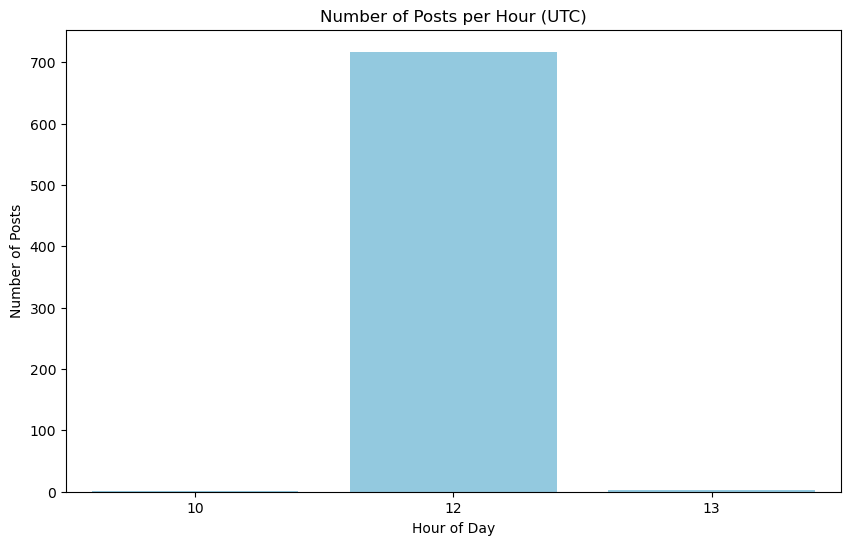

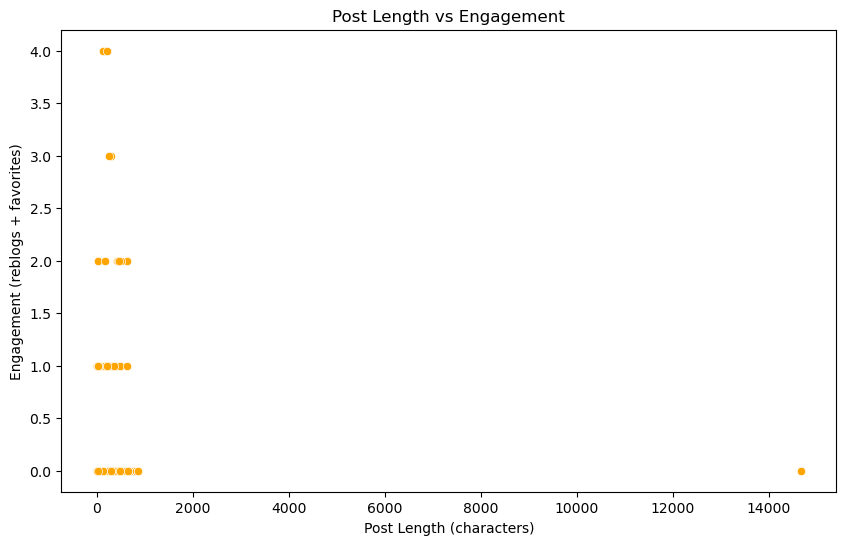

In [124]:
#Visualizations 
#Posts per hour
plt.figure(figsize=(10,6))
sns.barplot(x=posts_per_hour.index, y=posts_per_hour.values, color="skyblue")
plt.title("Number of Posts per Hour (UTC)")
plt.xlabel("Hour of Day")
plt.ylabel("Number of Posts")
plt.show()

#Post length vs Engagement
plt.figure(figsize=(10,6))
sns.scatterplot(x="content_length", y="engagement", data=df, color="orange")
plt.title("Post Length vs Engagement")
plt.xlabel("Post Length (characters)")
plt.ylabel("Engagement (reblogs + favorites)")
plt.show()


In [125]:
#Summarys

print("Average post length:", df['content_length'].mean())
print("Average engagement per post:", df['engagement'].mean())
print("Top 5 most active users:")
print(df['username'].value_counts().head())

Average post length: 217.67361111111111
Average engagement per post: 0.16805555555555557
Top 5 most active users:
username
noticiaconectada    12
odnewsin            11
renseiP             10
YahooFinance        10
Carboxy_P            6
Name: count, dtype: int64


Correlation between post length and engagement: -0.02

Descriptive statistics for content length:
count      720.000000
mean       217.673611
std        568.401935
min          0.000000
25%         56.000000
50%        138.500000
75%        294.000000
max      14678.000000
Name: content_length, dtype: float64

Descriptive statistics for engagement:
count    720.000000
mean       0.168056
std        0.463801
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        4.000000
Name: engagement, dtype: float64

Top 10 users by number of posts:
username
noticiaconectada    12
odnewsin            11
renseiP             10
YahooFinance        10
Carboxy_P            6
HesaplaGo            6
saimin_collect       6
news.err.ee          5
sibakari             5
vietworldnow         5
Name: count, dtype: int64

Average engagement per hour:
hour
10    0.000000
12    0.168759
13    0.000000
Name: engagement, dtype: float64


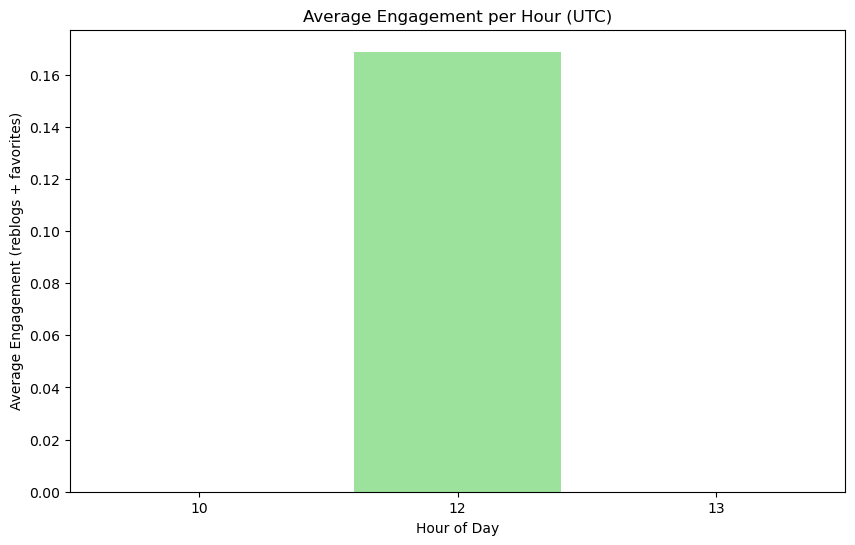

In [126]:
#Correlation between post length and engagement 
correlation = df['content_length'].corr(df['engagement'])
print(f"Correlation between post length and engagement: {correlation:.2f}")

# Descriptive statistics 
print("\nDescriptive statistics for content length:")
print(df['content_length'].describe())

print("\nDescriptive statistics for engagement:")
print(df['engagement'].describe())

#Top users by number of posts
top_users = df['username'].value_counts().head(10)
print("\nTop 10 users by number of posts:")
print(top_users)

#Average engagement per hour
avg_engagement_hour = df.groupby('hour')['engagement'].mean()
print("\nAverage engagement per hour:")
print(avg_engagement_hour)

#Visualization: Average engagement per hour
plt.figure(figsize=(10,6))
sns.barplot(x=avg_engagement_hour.index, y=avg_engagement_hour.values, color="lightgreen")
plt.title("Average Engagement per Hour (UTC)")
plt.xlabel("Hour of Day")
plt.ylabel("Average Engagement (reblogs + favorites)")
plt.show()

